In [1]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_io as tfio

In [8]:
CapuchianBird_files = os.path.join("samples", "Parsed_Capuchinbird_Clips", "XC114132-0.wav")
notCapuchianBird_files = os.path.join("samples", "Parsed_Not_Capuchinbird_Clips", "afternoon-birds-song-in-forest-16.wav")

In [9]:
CapuchianBird_files

'samples\\Parsed_Capuchinbird_Clips\\XC114132-0.wav'

In [10]:
notCapuchianBird_files

'samples\\Parsed_Not_Capuchinbird_Clips\\afternoon-birds-song-in-forest-16.wav'

In [55]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## Plot the wave for the samples through the function above

In [12]:
wave_capuchian = load_wav_16k_mono(CapuchianBird_files)
wave_non_capuchian = load_wav_16k_mono(notCapuchianBird_files)

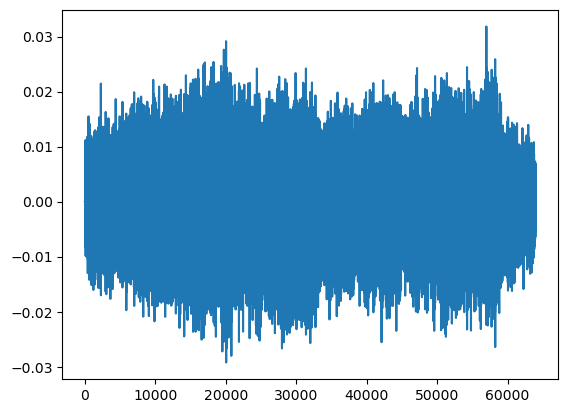

In [15]:
plt.plot(wave_capuchian)
plt.show()

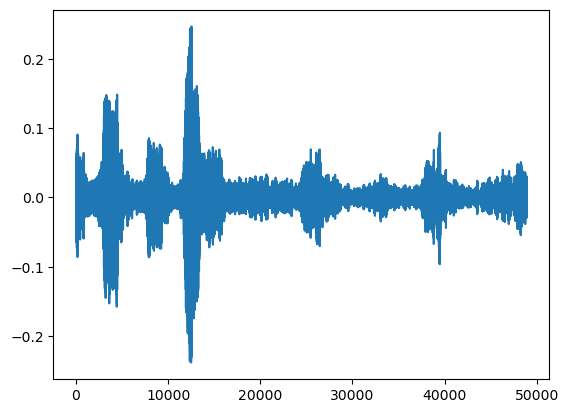

In [14]:
plt.plot(wave_non_capuchian)
plt.show()

#### We have now processed one of each audio sample

# Build the Spectrogram

We proceed to load the entire datasets to build the deep learning model.

In [18]:
Capuchian_Birds = os.path.join("samples", "Parsed_Capuchinbird_Clips")
Non_Capuchian_Birds = os.path.join("samples", "Parsed_Not_Capuchinbird_Clips")

Load all the data in the tensorflow datasets format

In [20]:
Capuchian_Birds_data = tf.data.Dataset.list_files(Capuchian_Birds+"\*.wav")
Non_Capuchian_Birds_data = tf.data.Dataset.list_files(Non_Capuchian_Birds+"\*.wav")

In [21]:
cap_bird = tf.data.Dataset.zip((Capuchian_Birds_data, tf.data.Dataset.from_tensor_slices(tf.ones(len(Capuchian_Birds_data)))))
non_cap_bird = tf.data.Dataset.zip((Non_Capuchian_Birds_data, tf.data.Dataset.from_tensor_slices(tf.zeros(len(Non_Capuchian_Birds_data)))))

In [22]:
cap_bird.as_numpy_iterator().next()

(b'samples\\Parsed_Capuchinbird_Clips\\XC201990-2.wav', 1.0)

The output above gives a random capuchian bird string file with a binary flag 1.0.(This denotes that the file is for a capuchian bird call)

In [23]:
non_cap_bird.as_numpy_iterator().next()

(b'samples\\Parsed_Not_Capuchinbird_Clips\\rain-thunder-and-crickets-sound-effect-34.wav',
 0.0)

The output above gives a random Non-capuchian bird string file with a binary flag 0.0.(This denotes that the file is for a Non-capuchian bird call)

### We then concatinate the two into one variable.

In [24]:
data = cap_bird.concatenate(non_cap_bird)

In [46]:
data.shuffle(1000).as_numpy_iterator().next()

(b'samples\\Parsed_Capuchinbird_Clips\\XC600460-4.wav', 1.0)

In [48]:
length_of_call = []

for file in os.listdir(os.path.join("samples", "Parsed_Capuchinbird_Clips")):
    waveform = load_wav_16k_mono(os.path.join("samples", "Parsed_Capuchinbird_Clips", file))
    length_of_call.append(len(waveform))

## We then look at the summary statistics for the audio

In [49]:
tf.math.reduce_mean(length_of_call)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [52]:
# 54156 Hz, 16000 Hz
mean_length_of_sound = 54156/16000
print(f"Avg capuchian sound is: {mean_length_of_sound}seconds")

Avg capuchian sound is: 3.38475seconds


In [50]:
tf.math.reduce_min(length_of_call)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [53]:
# 32000 Hz, 16000 Hz
minimum_length_of_sound = 32000/16000
print(f"Minimun capuchian sound recorded is: {minimum_length_of_sound}seconds")

Minimun capuchian sound recorded is: 2.0seconds


In [51]:
tf.math.reduce_max(length_of_call)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [54]:
# 80000 Hz, 16000 Hz
maximum_length_of_sound = 80000/16000
print(f"maximum capuchian sound recorded is: {maximum_length_of_sound}seconds")

maximum capuchian sound recorded is: 5.0seconds


* The capuchian bird calls are between 2 seconds and 5 seconds in length

## We then convert the data into a spectrogram using tensorflow and using the short time fourier transform (STFT)

In [71]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000] # This takes 48000 samples(a number higher than the minimum_length_of_sound)
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32) # Adds zeros for all samples less than 48000
    wav = tf.concat([zero_padding, wav],0) # Concatinating the zeros file with WAV file to give the final file for the spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2) # Adds a set of channels
    return spectrogram, label

### Visualise the sprectrogram for both capuchian and non_capuchian bird calls 

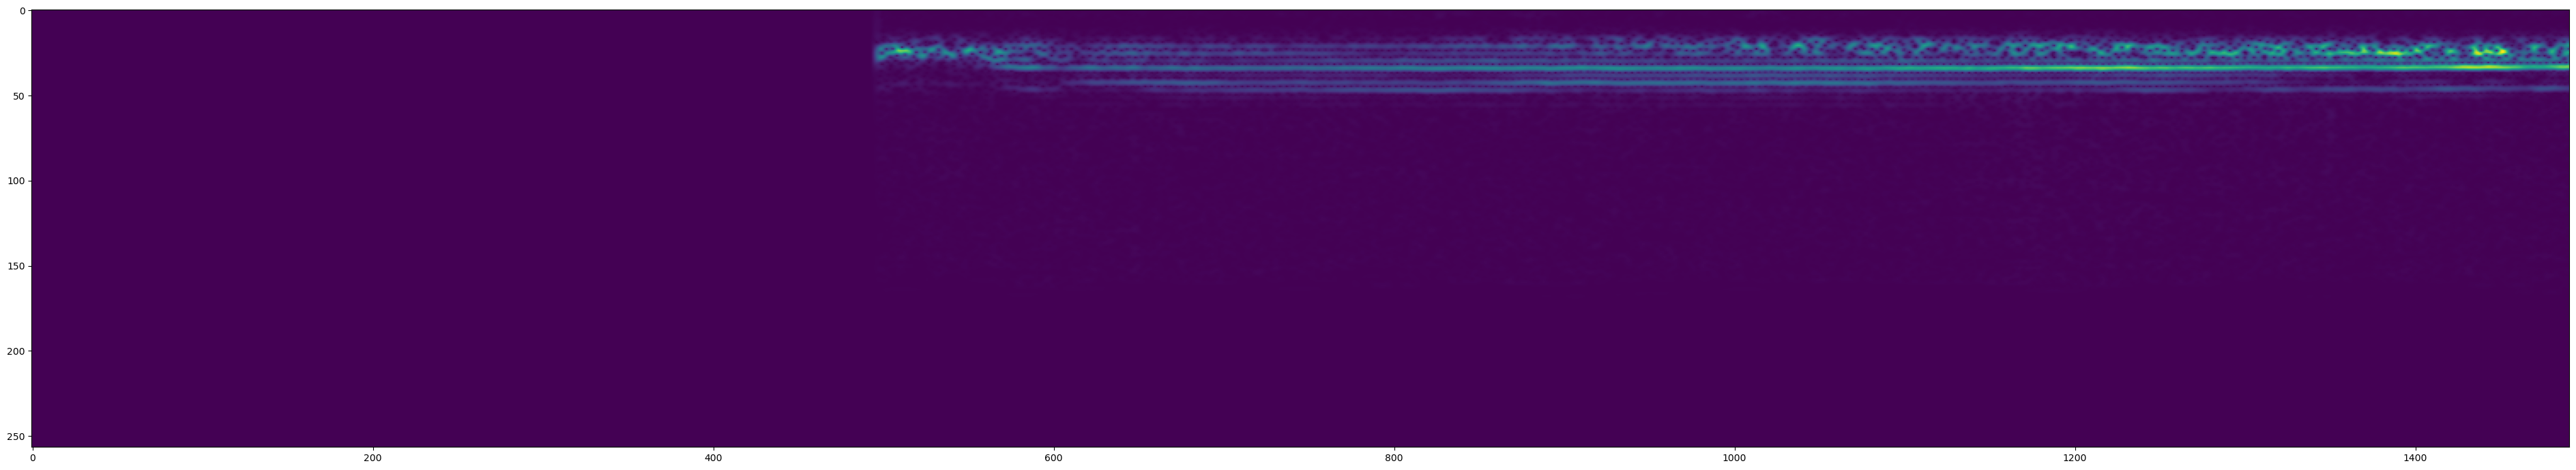

In [84]:
filepath, label = cap_bird.shuffle(buffer_size = 10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(48,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

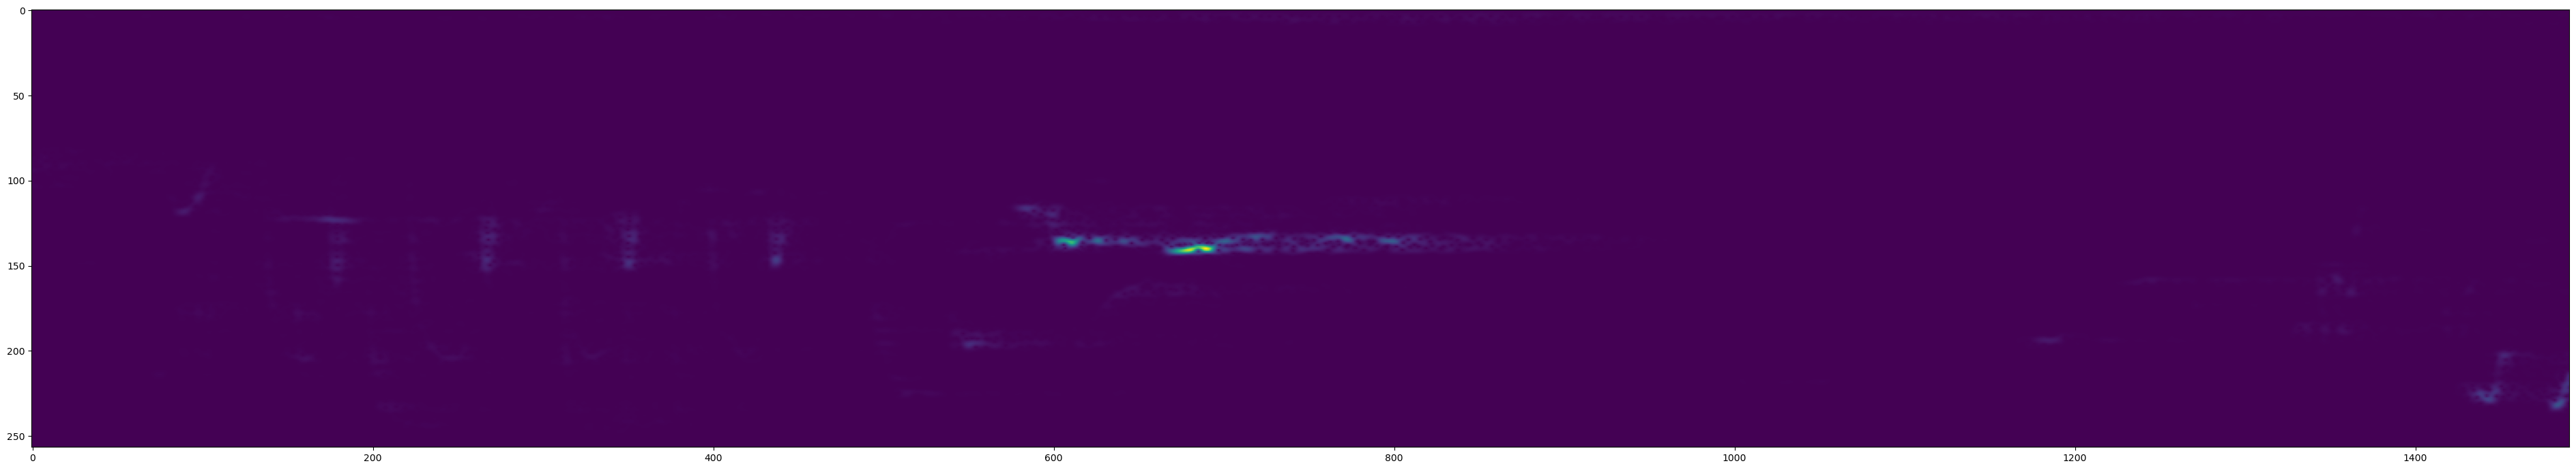

In [85]:
filepath, label = non_cap_bird.shuffle(buffer_size = 10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(48,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Split the data into training and test sets

We first run the data into the spectrogram function

In [86]:
data = data.map(preprocess)
data = data.cache() 
data = data.shuffle(buffer_size=1000) # Mix the training and test set( prevents overfitting or introducing any bias into the model)
data = data.batch(16) # Train on 16 samples at a time
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [87]:
len(data)

51

Let's take 80% for the training set and 20 for the testing set.

In [88]:
len(data)*.8

40.800000000000004

In [89]:
train = data.take(40)
test = data.skip(40).take(11)

In [91]:
samples, labels = train.as_numpy_iterator().next()

In [92]:
samples.shape

(16, 1491, 257, 1)

# Build the Deep Learning model

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D

In [104]:
cnn = Sequential()
cnn.add(Conv2D(filters=16, kernel_size=3, activation="relu", input_shape=[1491,257,1]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(Conv2D(filters=16, kernel_size=3, activation="relu"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.5))
cnn.add(Flatten())
cnn.add(Dense(128, activation="relu"))

cnn.add(Dense(1, activation="sigmoid"))

## Compile the model

In [111]:
cnn.compile("Adam", loss="BinaryCrossentropy", metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [112]:
cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_14 (Conv2D)          (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 371, 62, 16)       0         
                                                                 
 flatten_5 (Flatten)         (None, 368032)           

In [113]:
hist = cnn.fit(train, epochs=10, validation_data=test)

Epoch 1/10
40/40 [==============================] - 178s 4s/step - loss: 0.4807 - recall_1: 0.8727 - precision_1: 0.8780 - val_loss: 0.0078 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 2/10
40/40 [==============================] - 152s 4s/step - loss: 0.0378 - recall_1: 0.9820 - precision_1: 0.9880 - val_loss: 0.0108 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 3/10
40/40 [==============================] - 148s 4s/step - loss: 0.0078 - recall_1: 0.9939 - precision_1: 1.0000 - val_loss: 0.0014 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 4/10
40/40 [==============================] - 152s 4s/step - loss: 0.0031 - recall_1: 1.0000 - precision_1: 1.0000 - val_loss: 0.0077 - val_recall_1: 0.9773 - val_precision_1: 1.0000
Epoch 5/10
40/40 [==============================] - 151s 4s/step - loss: 0.0111 - recall_1: 0.9890 - precision_1: 0.9890 - val_loss: 1.4673e-04 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 6/10
40/40 [==============================] -

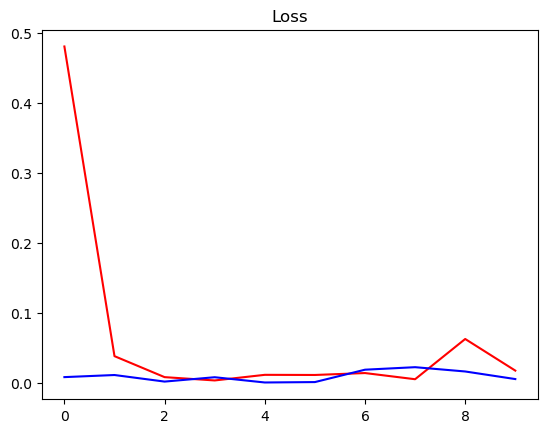

In [118]:
plt.title("Loss")
plt.plot(hist.history["loss"], "r")
plt.plot(hist.history["val_loss"], "b")
plt.show()

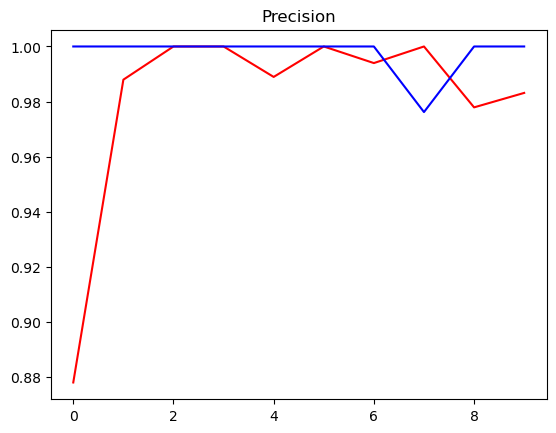

In [123]:
plt.title("Precision")
plt.plot(hist.history["precision_1"], "r")
plt.plot(hist.history["val_precision_1"], "b")
plt.show()

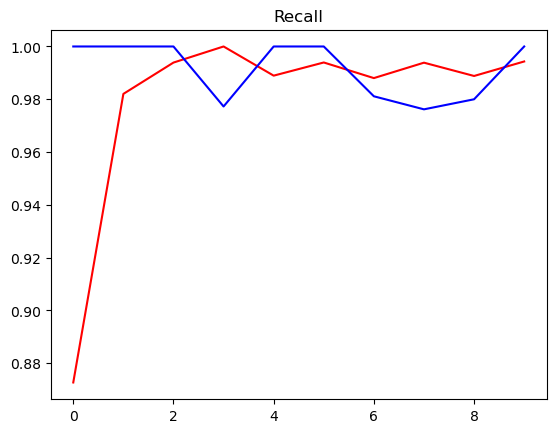

In [124]:
plt.title("Recall")
plt.plot(hist.history["recall_1"], "r")
plt.plot(hist.history["val_recall_1"], "b")
plt.show()

In [127]:
hist.history

{'loss': [0.4806588292121887,
  0.03779556602239609,
  0.007780309766530991,
  0.003051085164770484,
  0.011075516231358051,
  0.010881016030907631,
  0.013623295351862907,
  0.004801107104867697,
  0.06234266608953476,
  0.017121735960245132],
 'recall_1': [0.8727272748947144,
  0.9820359349250793,
  0.9939024448394775,
  1.0,
  0.988950252532959,
  0.9939393997192383,
  0.9880239367485046,
  0.9938650131225586,
  0.9888268113136292,
  0.9943181872367859],
 'precision_1': [0.8780487775802612,
  0.9879518151283264,
  1.0,
  1.0,
  0.988950252532959,
  1.0,
  0.9939758777618408,
  1.0,
  0.9779005646705627,
  0.983146071434021],
 'val_loss': [0.00781385786831379,
  0.010817371308803558,
  0.001426570350304246,
  0.007651716936379671,
  0.00014672648103442043,
  0.0007154897903092206,
  0.01842563971877098,
  0.02201356552541256,
  0.015881681814789772,
  0.005021349526941776],
 'val_recall_1': [1.0,
  1.0,
  1.0,
  0.9772727489471436,
  1.0,
  1.0,
  0.9811320900917053,
  0.976190447807

## Make Predictions from the model
* X_test = Spectrograms
* y_test = Label

In [128]:
X_test, y_test = test.as_numpy_iterator().next()

In [129]:
X_test.shape

(16, 1491, 257, 1)

In [130]:
y_test.shape

(16,)

In [131]:
yhat = cnn.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [132]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [133]:
yhat

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [134]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [135]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=3.0>

3 capuchian birds were heard in this batch and is accurate to the y_test

## Load the mp3 files and find capuchian bird calls from the longer audio clips

In [136]:
def load_mp3_16k_mono(filename):
    #Take the mp3 file and convert to tensor
    res = tfio.audio.AudioIOTensor(filename)
    
    # Since the audio is multichannel, we take the tensor and add the channel and then divideit by 2 to get one channel 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

### Load one recording 

In [137]:
mp3_clip = os.path.join("samples", "Forest Recordings", "recording_34.mp3")

In [138]:
load_mp3_file = load_mp3_16k_mono(mp3_clip)

We then convert the large audio file above into slices. This is done by slicing the long clip into smaller sizes equal to the size passed to the model. This means we are performing multiple predictions on a single audio clip.

In [139]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(load_mp3_file, load_mp3_file, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [140]:
samples, index = audio_slices.as_numpy_iterator().next()

In [141]:
len(audio_slices)

60

The audio has now been sliced into 60 windows which will be looped through ,converting them into spectrograms and making predictions for each window.

In [142]:
samples.shape

(1, 48000)

In [143]:
def preprocess_mp3(sample, index):
    sample = sample[0] # removing the channel at the start
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

### Convert the audio slices into spectrograms

In [144]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(load_mp3_file, load_mp3_file, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [149]:
yhat = cnn.predict(audio_slices)
# increase the confidence to 99%
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 4s 4s/step


In [150]:
len(yhat)

60

We get 60 predictions for each of the 60 windows stored in yhat

In [151]:
yhat

[0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In the above list of predicctions, there are consecutive predictions. This means consecutive calls are placed as additional predictions. We will group the consecutive predictions so that they are treated as a single call.

## Grouping the consecutive detections

In [152]:
from itertools import groupby

In [153]:
yhat = [key for key, group in groupby(yhat)]
capuchian_calls_detected = tf.math.reduce_sum(yhat).numpy()

In [154]:
capuchian_calls_detected

4

In the single clip loaded, the model detects 4 capuchian bird calls

# Make predictions on each of the mp3 files

In [155]:
results = {}
for file in os.listdir(os.path.join("samples", "Forest Recordings")):
    FILEPATH = os.path.join("samples","Forest Recordings", file)
    
    load_mp3_file = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(load_mp3_file, load_mp3_file, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = cnn.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 4s 4s/step


## Convert the predictions into classes for each mp3 audio clip 

In [157]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

## Group thee consecutive predictions for each mp3 audio clip

In [158]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 21,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_18.mp3': 2,
 'recording_19.mp3': 1,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 14,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 15,
 'recording_29.mp3': 0,
 'recording_30.mp3': 1,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 4,
 'recording_38.mp3': 1,
 'recording_39.mp3': 8,
 'recording_40.mp3': 1,
 'recording_4

## Export the results into a csv file

In [159]:
import csv

In [160]:
with open("Bird_Calls.csv", "w", newline="") as f:
    writer = csv.writer(f, delimiter=",")
    writer.writerow(["recording", "Number of Calls"])
    for key, value in postprocessed.items():
        writer.writerow([key, value])